# Exploratory Data Analysis (EDA) for MIP-PET Tumor Segmentation

This notebook provides an analysis of the PET scan dataset for tumor segmentation and classification tasks.

**Dataset Structure:**
- **Patient Images**: MIP-PET scans with tumors
- **Segmentation Labels**: Ground truth tumor masks
- **Control Images**: Healthy MIP-PET scans without tumors

## 1. Setup and Imports

In [1]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from collections import Counter
from tqdm import tqdm

## 2. Dataset Structure Verification

In [2]:
# Check data directory structure
import os

# Define data paths
data_dir = '/work/IdaHayJørgensen#9284/data'

print("🔍 Checking data structure...")

if os.path.exists(data_dir):
    print("✅ Data directory found!")
    
    # Check main folders
    patients_dir = os.path.join(data_dir, 'patients')
    controls_dir = os.path.join(data_dir, 'controls')
    
    print(f"📁 Patients folder exists: {os.path.exists(patients_dir)}")
    print(f"📁 Controls folder exists: {os.path.exists(controls_dir)}")
    
    # Check subfolders
    if os.path.exists(patients_dir):
        patients_imgs = os.path.join(patients_dir, 'imgs')
        patients_labels = os.path.join(patients_dir, 'labels')
        print(f"   📷 Patient images: {os.path.exists(patients_imgs)}")
        print(f"   🏷️  Patient labels: {os.path.exists(patients_labels)}")
        
        if os.path.exists(patients_imgs):
            img_count = len([f for f in os.listdir(patients_imgs) if f.endswith('.png')])
            print(f"      Found {img_count} patient images")
            
        if os.path.exists(patients_labels):
            label_count = len([f for f in os.listdir(patients_labels) if f.endswith('.png')])
            print(f"      Found {label_count} patient labels")
    
    if os.path.exists(controls_dir):
        controls_imgs = os.path.join(controls_dir, 'imgs')
        print(f"   📷 Control images: {os.path.exists(controls_imgs)}")
        
        if os.path.exists(controls_imgs):
            control_count = len([f for f in os.listdir(controls_imgs) if f.endswith('.png')])
            print(f"      Found {control_count} control images")

else:
    print("❌ Data directory not found!")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Available directories: {[d for d in os.listdir('.') if os.path.isdir(d)]}")

🔍 Checking data structure...
✅ Data directory found!
📁 Patients folder exists: True
📁 Controls folder exists: True
   📷 Patient images: True
   🏷️  Patient labels: True
      Found 182 patient images
      Found 182 patient labels
   📷 Control images: True
      Found 426 control images


## 3. Dataset Statistics and Label Coverage Analysis

In [3]:
def analyze_dataset_statistics():
    """
    Comprehensive dataset statistics including file counts and label coverage.
    
    Returns:
        tuple: Lists of patient files, label files, control files, and matched patient numbers
    """
    # Define paths
    patients_imgs = os.path.join(data_dir, 'patients', 'imgs')
    patients_labels = os.path.join(data_dir, 'patients', 'labels')
    controls_imgs = os.path.join(data_dir, 'controls', 'imgs')
    
    # Count files
    patient_files = [f for f in os.listdir(patients_imgs) if f.endswith('.png')] if os.path.exists(patients_imgs) else []
    label_files = [f for f in os.listdir(patients_labels) if f.endswith('.png')] if os.path.exists(patients_labels) else []
    control_files = [f for f in os.listdir(controls_imgs) if f.endswith('.png')] if os.path.exists(controls_imgs) else []
    
    print("DATASET STATISTICS")
    print("=" * 60)
    print(f"Patient images with tumors:     {len(patient_files)}")
    print(f"Ground truth segmentation masks: {len(label_files)}")
    print(f"Healthy control images:         {len(control_files)}")
    print(f"Total images:                   {len(patient_files) + len(control_files)}")
    print()
    
    # Display file naming patterns
    print("File Naming Conventions:")
    if patient_files:
        print(f"  Patient files:  {patient_files[0]}, {patient_files[1]}, ...")
    if label_files:
        print(f"  Label files:    {label_files[0]}, {label_files[1]}, ...")
    print()
    
    # Extract numerical identifiers for matching
    patient_numbers = set()
    for f in patient_files:
        if f.startswith('patient_') and f.endswith('.png'):
            num = f.replace('patient_', '').replace('.png', '')
            patient_numbers.add(num)
    
    label_numbers = set()
    for f in label_files:
        if f.startswith('segmentation_') and f.endswith('.png'):
            num = f.replace('segmentation_', '').replace('.png', '')
            label_numbers.add(num)
    
    # Analyze label coverage
    matched_numbers = patient_numbers.intersection(label_numbers)
    missing_labels = patient_numbers - label_numbers
    extra_labels = label_numbers - patient_numbers
    
    print(f"Label Coverage Analysis:")
    print(f"  Patients with matching labels:  {len(matched_numbers)}/{len(patient_numbers)} ({len(matched_numbers)/len(patient_numbers)*100:.1f}%)")
    print(f"  Missing labels:                 {len(missing_labels)}")
    print(f"  Extra labels (no patient):      {len(extra_labels)}")
    
    if missing_labels:
        missing_list = sorted(list(missing_labels))[:5]
        print(f"  Examples of missing labels: {missing_list}")
    
    if extra_labels:
        extra_list = sorted(list(extra_labels))[:5]
        print(f"  Examples of extra labels:   {extra_list}")
    
    return patient_files, label_files, control_files, matched_numbers

# Execute analysis
patient_files, label_files, control_files, matched_numbers = analyze_dataset_statistics()

DATASET STATISTICS
Patient images with tumors:     182
Ground truth segmentation masks: 182
Healthy control images:         426
Total images:                   608

File Naming Conventions:
  Patient files:  patient_099.png, patient_127.png, ...
  Label files:    segmentation_124.png, segmentation_169.png, ...

Label Coverage Analysis:
  Patients with matching labels:  182/182 (100.0%)
  Missing labels:                 0
  Extra labels (no patient):      0


## 4. Patient-Label Pair Matching

In [4]:
def get_matching_pairs(patients_dir, labels_dir):
    """
    Identify and validate patient-label pairs based on file naming convention.
    
    Args:
        patients_dir (str): Directory containing patient images
        labels_dir (str): Directory containing segmentation labels
    
    Returns:
        list: List of tuples (patient_file, label_file) for matched pairs
    """
    patient_files = [f for f in os.listdir(patients_dir) if f.endswith('.png')]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.png')]
    
    matching_pairs = []
    
    for patient_file in patient_files:
        if patient_file.startswith('patient_'):
            # Extract numerical identifier
            number = patient_file.replace('patient_', '').replace('.png', '')
            
            # Construct expected label filename
            expected_label = f"segmentation_{number}.png"
            
            if expected_label in label_files:
                matching_pairs.append((patient_file, expected_label))
    
    print(f"Found {len(matching_pairs)} matching patient-label pairs")
    
    # Display sample pairs for verification
    print("\nSample matching pairs:")
    for i, (patient, label) in enumerate(matching_pairs[:5]):
        print(f"  {patient} ↔ {label}")
        
        # Verify file existence
        patient_path = os.path.join(patients_dir, patient)
        label_path = os.path.join(labels_dir, label)
        print(f"    Patient exists: {os.path.exists(patient_path)}")
        print(f"    Label exists:   {os.path.exists(label_path)}")
    
    return matching_pairs

# Get matching pairs
matching_pairs = get_matching_pairs(
    os.path.join(data_dir, 'patients', 'imgs'),
    os.path.join(data_dir, 'patients', 'labels')
)

Found 182 matching patient-label pairs

Sample matching pairs:
  patient_099.png ↔ segmentation_099.png
    Patient exists: True
    Label exists:   True
  patient_127.png ↔ segmentation_127.png
    Patient exists: True
    Label exists:   True
  patient_002.png ↔ segmentation_002.png
    Patient exists: True
    Label exists:   True
  patient_124.png ↔ segmentation_124.png
    Patient exists: True
    Label exists:   True
  patient_069.png ↔ segmentation_069.png
    Patient exists: True
    Label exists:   True


## 5. Visual Inspection of Sample Images

patient_099.png: Tumor coverage = 0.2507 (25.07%)
patient_127.png: Tumor coverage = 0.2641 (26.41%)
patient_002.png: Tumor coverage = 0.2560 (25.60%)


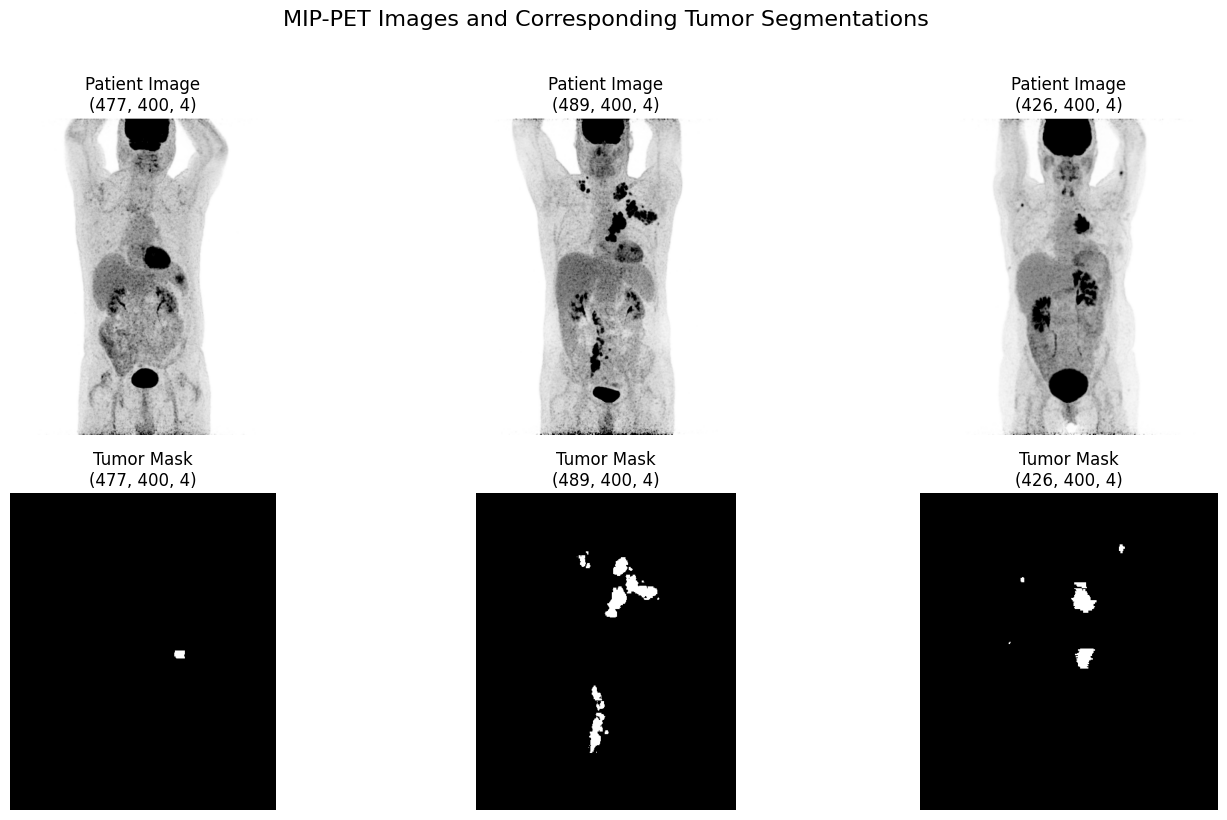

In [5]:
def visualize_sample_pairs(patients_dir, labels_dir, matching_pairs, n_samples=3):
    """
    Display sample patient images with corresponding segmentation masks.
    
    Args:
        patients_dir (str): Directory containing patient images
        labels_dir (str): Directory containing labels
        matching_pairs (list): List of matched patient-label pairs
        n_samples (int): Number of samples to display
    """
    if len(matching_pairs) == 0:
        print("Error: No matching pairs found")
        return
    
    sample_pairs = matching_pairs[:n_samples]
    
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))
    
    for i, (patient_file, label_file) in enumerate(sample_pairs):
        # Load images
        patient_path = os.path.join(patients_dir, patient_file)
        patient_img = Image.open(patient_path)
        patient_array = np.array(patient_img)
        
        label_path = os.path.join(labels_dir, label_file)
        label_img = Image.open(label_path)
        label_array = np.array(label_img)
        
        # Display patient image
        axes[0, i].imshow(patient_array, cmap='gray')
        axes[0, i].set_title(f'Patient Image\n{patient_array.shape}')
        axes[0, i].axis('off')
        
        # Display segmentation mask
        axes[1, i].imshow(label_array, cmap='gray')
        axes[1, i].set_title(f'Tumor Mask\n{label_array.shape}')
        axes[1, i].axis('off')
        
        # Calculate tumor coverage statistics
        tumor_pixels = np.sum(label_array > 127)
        total_pixels = label_array.size
        tumor_ratio = tumor_pixels / total_pixels
        print(f"{patient_file}: Tumor coverage = {tumor_ratio:.4f} ({tumor_ratio*100:.2f}%)")
    
    plt.suptitle('MIP-PET Images and Corresponding Tumor Segmentations', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_sample_pairs(
    os.path.join(data_dir, 'patients', 'imgs'),
    os.path.join(data_dir, 'patients', 'labels'),
    matching_pairs
)

## 6. Image Dimensions Analysis

In [6]:
def analyze_image_dimensions(patients_dir, controls_dir, labels_dir):
    """
    Analyze image dimension distributions across the dataset.
    
    Args:
        patients_dir (str): Directory containing patient images
        controls_dir (str): Directory containing control images
        labels_dir (str): Directory containing labels
    
    Returns:
        tuple: Recommended target width and height for preprocessing
    """
    print("IMAGE DIMENSIONS ANALYSIS")
    print("=" * 60)
    
    # Collect dimension data
    all_dimensions = {'patients': [], 'controls': [], 'labels': []}
    
    # Analyze patient images
    if os.path.exists(patients_dir):
        patient_files = [f for f in os.listdir(patients_dir) if f.endswith('.png')]
        for file in patient_files:
            img = Image.open(os.path.join(patients_dir, file))
            all_dimensions['patients'].append(img.size)
    
    # Analyze control images
    if os.path.exists(controls_dir):
        control_files = [f for f in os.listdir(controls_dir) if f.endswith('.png')]
        for file in control_files:
            img = Image.open(os.path.join(controls_dir, file))
            all_dimensions['controls'].append(img.size)
    
    # Analyze label images
    if os.path.exists(labels_dir):
        label_files = [f for f in os.listdir(labels_dir) if f.endswith('.png')]
        for file in label_files:
            img = Image.open(os.path.join(labels_dir, file))
            all_dimensions['labels'].append(img.size)
    
    # Statistical analysis
    for category, dimensions in all_dimensions.items():
        if dimensions:
            widths = [d[0] for d in dimensions]
            heights = [d[1] for d in dimensions]
            
            print(f"\n{category.upper()}:")
            print(f"  Sample count:   {len(dimensions)}")
            print(f"  Width range:    [{min(widths)}, {max(widths)}], mean={np.mean(widths):.1f}")
            print(f"  Height range:   [{min(heights)}, {max(heights)}], mean={np.mean(heights):.1f}")
            print(f"  Unique sizes:   {len(set(dimensions))}")
            
            # Most common dimensions
            size_counts = Counter(dimensions)
            most_common = size_counts.most_common(3)
            print(f"  Most common dimensions: {most_common}")
    
    # Recommend target size for standardization
    all_patient_dimensions = all_dimensions['patients']
    if all_patient_dimensions:
        all_widths = [d[0] for d in all_patient_dimensions]
        all_heights = [d[1] for d in all_patient_dimensions]
        
        target_width = int(np.median(all_widths))
        target_height = int(np.median(all_heights))
        
        print(f"\nRECOMMENDATION:")
        print(f"  Target size for preprocessing: {target_width} x {target_height}")
        print(f"  Rationale: Median dimensions minimize information loss during resizing")
        
        return target_width, target_height
    
    return None, None

# Analyze dimensions
target_w, target_h = analyze_image_dimensions(
    os.path.join(data_dir, 'patients', 'imgs'),
    os.path.join(data_dir, 'controls', 'imgs'),
    os.path.join(data_dir, 'patients', 'labels')
)

IMAGE DIMENSIONS ANALYSIS

PATIENTS:
  Sample count:   182
  Width range:    [400, 400], mean=400.0
  Height range:   [423, 979], mean=499.4
  Unique sizes:   37
  Most common dimensions: [((400, 489), 79), ((400, 426), 58), ((400, 552), 4)]

CONTROLS:
  Sample count:   426
  Width range:    [400, 400], mean=400.0
  Height range:   [300, 991], mean=515.3
  Unique sizes:   105
  Most common dimensions: [((400, 489), 106), ((400, 426), 65), ((400, 363), 18)]

LABELS:
  Sample count:   182
  Width range:    [400, 400], mean=400.0
  Height range:   [423, 979], mean=499.4
  Unique sizes:   37
  Most common dimensions: [((400, 489), 79), ((400, 426), 58), ((400, 552), 4)]

RECOMMENDATION:
  Target size for preprocessing: 400 x 489
  Rationale: Median dimensions minimize information loss during resizing


## 7. Pixel Intensity Distribution Analysis

In [7]:
def analyze_pixel_intensities(patients_dir, controls_dir, sample_size=50):
    """
    Analyze pixel intensity distributions for normalization parameter estimation.
    
    Args:
        patients_dir (str): Directory containing patient images
        controls_dir (str): Directory containing control images
        sample_size (int): Number of images to sample per category
    
    Returns:
        tuple: Dataset mean and standard deviation for normalization
    """
    print("PIXEL INTENSITY DISTRIBUTION ANALYSIS")
    print("=" * 60)
    
    # Sample images for analysis
    patient_files = [f for f in os.listdir(patients_dir) if f.endswith('.png')][:sample_size]
    control_files = [f for f in os.listdir(controls_dir) if f.endswith('.png')][:sample_size]
    
    patient_stats = {'min': [], 'max': [], 'mean': [], 'std': []}
    control_stats = {'min': [], 'max': [], 'mean': [], 'std': []}
    
    # Analyze patient images
    print(f"Analyzing {len(patient_files)} patient images...")
    for file in patient_files:
        img = np.array(Image.open(os.path.join(patients_dir, file)))
        patient_stats['min'].append(img.min())
        patient_stats['max'].append(img.max())
        patient_stats['mean'].append(img.mean())
        patient_stats['std'].append(img.std())
    
    # Analyze control images
    print(f"Analyzing {len(control_files)} control images...")
    for file in control_files:
        img = np.array(Image.open(os.path.join(controls_dir, file)))
        control_stats['min'].append(img.min())
        control_stats['max'].append(img.max())
        control_stats['mean'].append(img.mean())
        control_stats['std'].append(img.std())
    
    # Display statistics
    print(f"\nPATIENT IMAGES (n={len(patient_files)}):")
    for stat, values in patient_stats.items():
        print(f"  {stat.upper():6s}: min={np.min(values):7.1f}, max={np.max(values):7.1f}, "
              f"mean={np.mean(values):7.1f}, std={np.std(values):6.1f}")
    
    print(f"\nCONTROL IMAGES (n={len(control_files)}):")
    for stat, values in control_stats.items():
        print(f"  {stat.upper():6s}: min={np.min(values):7.1f}, max={np.max(values):7.1f}, "
              f"mean={np.mean(values):7.1f}, std={np.std(values):6.1f}")
    
    # Calculate global normalization parameters
    all_means = patient_stats['mean'] + control_stats['mean']
    all_stds = patient_stats['std'] + control_stats['std']
    
    dataset_mean = np.mean(all_means)
    dataset_std = np.mean(all_stds)
    
    print(f"\nNORMALIZATION PARAMETERS:")
    print(f"  Dataset mean: {dataset_mean:.4f}")
    print(f"  Dataset std:  {dataset_std:.4f}")
    print(f"  Formula: normalized_pixel = (pixel - {dataset_mean:.4f}) / {dataset_std:.4f}")
    
    return dataset_mean, dataset_std

# Calculate normalization parameters
dataset_mean, dataset_std = analyze_pixel_intensities(
    os.path.join(data_dir, 'patients', 'imgs'),
    os.path.join(data_dir, 'controls', 'imgs')
)

PIXEL INTENSITY DISTRIBUTION ANALYSIS
Analyzing 50 patient images...
Analyzing 50 control images...

PATIENT IMAGES (n=50):
  MIN   : min=    0.0, max=    0.0, mean=    0.0, std=   0.0
  MAX   : min=  255.0, max=  255.0, mean=  255.0, std=   0.0
  MEAN  : min=  213.7, max=  240.1, mean=  228.9, std=   4.9
  STD   : min=   37.3, max=   61.0, mean=   50.3, std=   5.5

CONTROL IMAGES (n=50):
  MIN   : min=    0.0, max=    0.0, mean=    0.0, std=   0.0
  MAX   : min=  255.0, max=  255.0, mean=  255.0, std=   0.0
  MEAN  : min=  213.5, max=  236.4, mean=  228.9, std=   4.9
  STD   : min=   37.8, max=   61.0, mean=   48.4, std=   5.3

NORMALIZATION PARAMETERS:
  Dataset mean: 228.8747
  Dataset std:  49.3409
  Formula: normalized_pixel = (pixel - 228.8747) / 49.3409


## 8. Preprocessing Functions

In [8]:
def preprocess_image(img_path, target_size=(256, 256), normalize=True, mean=None, std=None):
    """
    Preprocess a medical image: resize and normalize.
    
    Args:
        img_path (str): Path to image file
        target_size (tuple): Target dimensions (width, height)
        normalize (bool): Whether to apply normalization
        mean (float): Mean for normalization
        std (float): Standard deviation for normalization
    
    Returns:
        np.ndarray: Preprocessed image
    """
    # Load image
    img = Image.open(img_path)
    img_array = np.array(img)
    
    # Convert to grayscale if necessary
    if len(img_array.shape) == 3:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    # Resize image using bilinear interpolation
    img_resized = cv2.resize(img_array, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Apply normalization
    if normalize and mean is not None and std is not None:
        img_normalized = (img_resized.astype(np.float32) - mean) / std
        return img_normalized
    else:
        # Simple scaling to [0, 1]
        return img_resized.astype(np.float32) / 255.0

def preprocess_label(label_path, target_size=(256, 256)):
    """
    Preprocess a segmentation mask: resize and binarize.
    
    Args:
        label_path (str): Path to label file
        target_size (tuple): Target dimensions (width, height)
    
    Returns:
        np.ndarray: Binary mask (0 or 1)
    """
    # Load label
    label = Image.open(label_path)
    label_array = np.array(label)
    
    # Convert to grayscale if necessary
    if len(label_array.shape) == 3:
        label_array = cv2.cvtColor(label_array, cv2.COLOR_RGB2GRAY)
    
    # Resize using nearest neighbor to preserve binary values
    label_resized = cv2.resize(label_array, target_size, interpolation=cv2.INTER_NEAREST)
    
    # Binarize: tumor region = 1, background = 0
    binary_mask = (label_resized > 127).astype(np.float32)
    
    return binary_mask

## 9. Preprocessing Validation

PREPROCESSING VALIDATION
Original image:      shape=(477, 400, 4), dtype=uint8, range=[0, 255]
Preprocessed image:  shape=(256, 256), dtype=float64, range=[-4.639, 0.529]
Original label:      shape=(477, 400, 4), dtype=uint8, range=[0, 255]
Preprocessed label:  shape=(256, 256), dtype=float32, range=[0.0, 1.0]


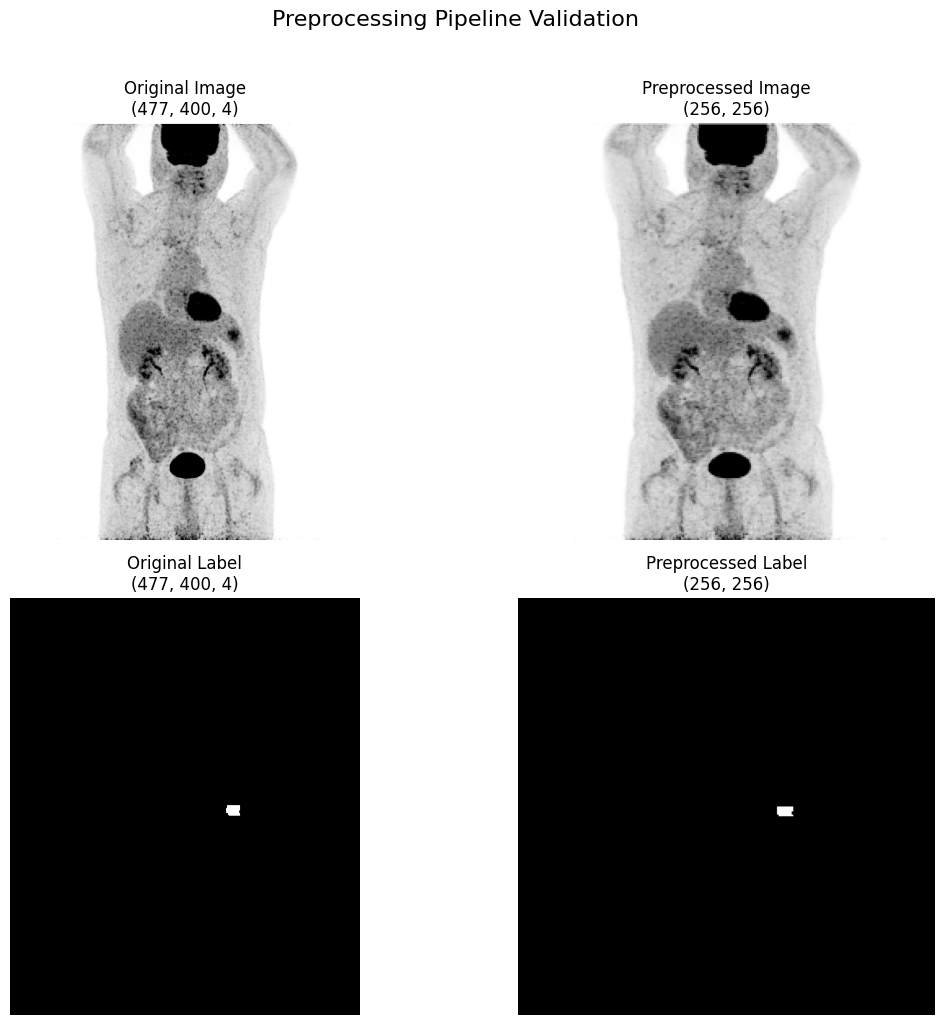

In [9]:
# Test preprocessing pipeline on sample data
print("PREPROCESSING VALIDATION")
print("=" * 60)

if matching_pairs:
    # Select first matching pair
    patient_file, label_file = matching_pairs[0]
    
    patient_path = os.path.join(data_dir, 'patients', 'imgs', patient_file)
    label_path = os.path.join(data_dir, 'patients', 'labels', label_file)
    
    # Load original images
    orig_img = np.array(Image.open(patient_path))
    orig_label = np.array(Image.open(label_path))
    
    # Apply preprocessing
    prep_img = preprocess_image(patient_path, target_size=(256, 256), 
                                normalize=True, mean=dataset_mean, std=dataset_std)
    prep_label = preprocess_label(label_path, target_size=(256, 256))
    
    # Display statistics
    print(f"Original image:      shape={orig_img.shape}, dtype={orig_img.dtype}, range=[{orig_img.min()}, {orig_img.max()}]")
    print(f"Preprocessed image:  shape={prep_img.shape}, dtype={prep_img.dtype}, range=[{prep_img.min():.3f}, {prep_img.max():.3f}]")
    print(f"Original label:      shape={orig_label.shape}, dtype={orig_label.dtype}, range=[{orig_label.min()}, {orig_label.max()}]")
    print(f"Preprocessed label:  shape={prep_label.shape}, dtype={prep_label.dtype}, range=[{prep_label.min()}, {prep_label.max()}]")
    
    # Visualize preprocessing results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0, 0].imshow(orig_img, cmap='gray')
    axes[0, 0].set_title(f'Original Image\n{orig_img.shape}')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(prep_img, cmap='gray')
    axes[0, 1].set_title(f'Preprocessed Image\n{prep_img.shape}')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(orig_label, cmap='gray')
    axes[1, 0].set_title(f'Original Label\n{orig_label.shape}')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(prep_label, cmap='gray')
    axes[1, 1].set_title(f'Preprocessed Label\n{prep_label.shape}')
    axes[1, 1].axis('off')
    
    plt.suptitle('Preprocessing Pipeline Validation', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

else:
    print("Error: No matching pairs available for validation")

## 10. Save Preprocessed Dataset

This section provides functionality to save preprocessed images to disk for faster training later.

In [10]:
from sklearn.model_selection import train_test_split

def save_preprocessed_dataset_with_split(data_dir, output_dir, target_size=(256, 256), 
                                         train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                         random_seed=42):
    """
    Save preprocessed images to disk with train/val/test split.
    
    Args:
        data_dir (str): Source data directory
        output_dir (str): Output directory for preprocessed data
        target_size (tuple): Target dimensions
        train_ratio (float): Proportion for training (default: 0.7)
        val_ratio (float): Proportion for validation (default: 0.15)
        test_ratio (float): Proportion for testing (default: 0.15)
        random_seed (int): Random seed for reproducibility
    """
    import shutil
    from collections import Counter
    
    print("SAVING PREPROCESSED DATASET WITH TRAIN/VAL/TEST SPLIT")
    print("=" * 70)
    
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    patient_samples = []
    for patient_file, label_file in matching_pairs:
        patient_samples.append((patient_file, label_file))
    
    controls_dir = os.path.join(data_dir, 'controls', 'imgs')
    control_files = [f for f in os.listdir(controls_dir) if f.endswith('.png')]
    
    print(f"\n📊 Dataset Overview:")
    print(f"  Patients (with tumors): {len(patient_samples)}")
    print(f"  Controls (healthy): {len(control_files)}")
    print(f"  Total: {len(patient_samples) + len(control_files)}")
    
    print(f"\n📂 Splitting patients into train/val/test...")
    
    patient_indices = list(range(len(patient_samples)))
    
    train_patient_idx, temp_patient_idx = train_test_split(
        patient_indices,
        test_size=(val_ratio + test_ratio),
        random_state=random_seed
    )
    
    val_size = val_ratio / (val_ratio + test_ratio)
    val_patient_idx, test_patient_idx = train_test_split(
        temp_patient_idx,
        test_size=(1 - val_size),
        random_state=random_seed
    )
    
    print(f"  Train patients: {len(train_patient_idx)}")
    print(f"  Val patients: {len(val_patient_idx)}")
    print(f"  Test patients: {len(test_patient_idx)}")
    
    print(f"\n📂 Splitting controls into train/val/test...")
    
    control_indices = list(range(len(control_files)))
    
    train_control_idx, temp_control_idx = train_test_split(
        control_indices,
        test_size=(val_ratio + test_ratio),
        random_state=random_seed
    )
    
    val_control_idx, test_control_idx = train_test_split(
        temp_control_idx,
        test_size=(1 - val_size),
        random_state=random_seed
    )
    
    print(f"  Train controls: {len(train_control_idx)}")
    print(f"  Val controls: {len(val_control_idx)}")
    print(f"  Test controls: {len(test_control_idx)}")
    
    print(f"\n📁 Creating directory structure...")
    
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split, 'patients', 'imgs'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, 'patients', 'labels'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, 'controls', 'imgs'), exist_ok=True)
    
    print(f"  ✓ Created train/val/test directories")
    
    split_mapping = {
        'train': train_patient_idx,
        'val': val_patient_idx,
        'test': test_patient_idx
    }
    
    print(f"\n🔄 Processing and saving patient images...")
    
    for split_name, indices in split_mapping.items():
        print(f"\n  Processing {split_name} patients ({len(indices)} pairs)...")
        
        for idx in tqdm(indices, desc=f"  {split_name.capitalize()} patients"):
            patient_file, label_file = patient_samples[idx]
            
            img_path = os.path.join(data_dir, 'patients', 'imgs', patient_file)
            prep_img = preprocess_image(img_path, target_size)
            
            prep_img_uint8 = ((prep_img - prep_img.min()) / (prep_img.max() - prep_img.min()) * 255).astype(np.uint8)
            
            output_img_path = os.path.join(output_dir, split_name, 'patients', 'imgs', patient_file)
            Image.fromarray(prep_img_uint8).save(output_img_path)
            
            label_path = os.path.join(data_dir, 'patients', 'labels', label_file)
            prep_label = preprocess_label(label_path, target_size)
            prep_label_uint8 = (prep_label * 255).astype(np.uint8)
            
            output_label_path = os.path.join(output_dir, split_name, 'patients', 'labels', label_file)
            Image.fromarray(prep_label_uint8).save(output_label_path)
    
    split_mapping_controls = {
        'train': train_control_idx,
        'val': val_control_idx,
        'test': test_control_idx
    }
    
    print(f"\n🔄 Processing and saving control images...")
    
    for split_name, indices in split_mapping_controls.items():
        print(f"\n  Processing {split_name} controls ({len(indices)} images)...")
        
        for idx in tqdm(indices, desc=f"  {split_name.capitalize()} controls"):
            control_file = control_files[idx]
            
            img_path = os.path.join(data_dir, 'controls', 'imgs', control_file)
            prep_img = preprocess_image(img_path, target_size)
            
            prep_img_uint8 = ((prep_img - prep_img.min()) / (prep_img.max() - prep_img.min()) * 255).astype(np.uint8)
            
            output_img_path = os.path.join(output_dir, split_name, 'controls', 'imgs', control_file)
            Image.fromarray(prep_img_uint8).save(output_img_path)
    
    print("\n" + "=" * 70)
    print("✅ PREPROCESSING AND SPLITTING COMPLETE!")
    print("=" * 70)
    print(f"\nDataset saved to: {output_dir}")
    print(f"\nFinal Split Summary:")
    print(f"  {'Split':<10} {'Patients':<12} {'Controls':<12} {'Total':<10}")
    print(f"  {'-'*10} {'-'*12} {'-'*12} {'-'*10}")
    print(f"  {'Train':<10} {len(train_patient_idx):<12} {len(train_control_idx):<12} {len(train_patient_idx)+len(train_control_idx):<10}")
    print(f"  {'Val':<10} {len(val_patient_idx):<12} {len(val_control_idx):<12} {len(val_patient_idx)+len(val_control_idx):<10}")
    print(f"  {'Test':<10} {len(test_patient_idx):<12} {len(test_control_idx):<12} {len(test_patient_idx)+len(test_control_idx):<10}")
    print(f"  {'-'*10} {'-'*12} {'-'*12} {'-'*10}")
    print(f"  {'Total':<10} {len(patient_samples):<12} {len(control_files):<12} {len(patient_samples)+len(control_files):<10}")
    
    print(f"\nDirectory structure:")
    print(f"  {output_dir}/")
    print(f"    ├── train/")
    print(f"    │   ├── controls/imgs/")
    print(f"    │   └── patients/")
    print(f"    │       ├── imgs/")
    print(f"    │       └── labels/")
    print(f"    ├── val/")
    print(f"    │   ├── controls/imgs/")
    print(f"    │   └── patients/")
    print(f"    │       ├── imgs/")
    print(f"    │       └── labels/")
    print(f"    └── test/")
    print(f"        ├── controls/imgs/")
    print(f"        └── patients/")
    print(f"            ├── imgs/")
    print(f"            └── labels/")


save_preprocessed_dataset_with_split(
    data_dir='/work/IdaHayJørgensen#9284/data',
    output_dir='/work/IdaHayJørgensen#9284/Notebooks/preprocessed_data',
    target_size=(256, 256),
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)

SAVING PREPROCESSED DATASET WITH TRAIN/VAL/TEST SPLIT

📊 Dataset Overview:
  Patients (with tumors): 182
  Controls (healthy): 426
  Total: 608

📂 Splitting patients into train/val/test...
  Train patients: 127
  Val patients: 27
  Test patients: 28

📂 Splitting controls into train/val/test...
  Train controls: 298
  Val controls: 64
  Test controls: 64

📁 Creating directory structure...
  ✓ Created train/val/test directories

🔄 Processing and saving patient images...

  Processing train patients (127 pairs)...


  Train patients: 100%|██████████| 127/127 [00:02<00:00, 50.08it/s]



  Processing val patients (27 pairs)...


  Val patients: 100%|██████████| 27/27 [00:00<00:00, 63.21it/s]



  Processing test patients (28 pairs)...


  Test patients: 100%|██████████| 28/28 [00:00<00:00, 79.09it/s]



🔄 Processing and saving control images...

  Processing train controls (298 images)...


  Train controls: 100%|██████████| 298/298 [00:02<00:00, 137.08it/s]



  Processing val controls (64 images)...


  Val controls: 100%|██████████| 64/64 [00:00<00:00, 137.67it/s]



  Processing test controls (64 images)...


  Test controls: 100%|██████████| 64/64 [00:00<00:00, 140.93it/s]


✅ PREPROCESSING AND SPLITTING COMPLETE!

Dataset saved to: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data

Final Split Summary:
  Split      Patients     Controls     Total     
  ---------- ------------ ------------ ----------
  Train      127          298          425       
  Val        27           64           91        
  Test       28           64           92        
  ---------- ------------ ------------ ----------
  Total      182          426          608       

Directory structure:
  /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/
    ├── train/
    │   ├── controls/imgs/
    │   └── patients/
    │       ├── imgs/
    │       └── labels/
    ├── val/
    │   ├── controls/imgs/
    │   └── patients/
    │       ├── imgs/
    │       └── labels/
    └── test/
        ├── controls/imgs/
        └── patients/
            ├── imgs/
            └── labels/


In [11]:
from sklearn.model_selection import train_test_split

def save_preprocessed_dataset_with_split(data_dir, output_dir, target_size=(256, 256), 
                                         train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                         random_seed=42):
    """
    Save preprocessed images to disk with train/val/test split.
    
    Args:
        data_dir (str): Source data directory
        output_dir (str): Output directory for preprocessed data
        target_size (tuple): Target dimensions
        train_ratio (float): Proportion for training (default: 0.7)
        val_ratio (float): Proportion for validation (default: 0.15)
        test_ratio (float): Proportion for testing (default: 0.15)
        random_seed (int): Random seed for reproducibility
    """
    import shutil
    from collections import Counter
    
    print("SAVING PREPROCESSED DATASET WITH TRAIN/VAL/TEST SPLIT")
    print("=" * 70)
    
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    patient_samples = []
    for patient_file, label_file in matching_pairs:
        patient_samples.append((patient_file, label_file))
    
    controls_dir = os.path.join(data_dir, 'controls', 'imgs')
    control_files = [f for f in os.listdir(controls_dir) if f.endswith('.png')]
    
    print(f"\n📊 Dataset Overview:")
    print(f"  Patients (with tumors): {len(patient_samples)}")
    print(f"  Controls (healthy): {len(control_files)}")
    print(f"  Total: {len(patient_samples) + len(control_files)}")
    
    print(f"\n📂 Splitting patients into train/val/test...")
    
    patient_indices = list(range(len(patient_samples)))
    
    train_patient_idx, temp_patient_idx = train_test_split(
        patient_indices,
        test_size=(val_ratio + test_ratio),
        random_state=random_seed
    )
    
    val_size = val_ratio / (val_ratio + test_ratio)
    val_patient_idx, test_patient_idx = train_test_split(
        temp_patient_idx,
        test_size=(1 - val_size),
        random_state=random_seed
    )
    
    print(f"  Train patients: {len(train_patient_idx)}")
    print(f"  Val patients: {len(val_patient_idx)}")
    print(f"  Test patients: {len(test_patient_idx)}")
    
    print(f"\n📂 Splitting controls into train/val/test...")
    
    control_indices = list(range(len(control_files)))
    
    train_control_idx, temp_control_idx = train_test_split(
        control_indices,
        test_size=(val_ratio + test_ratio),
        random_state=random_seed
    )
    
    val_control_idx, test_control_idx = train_test_split(
        temp_control_idx,
        test_size=(1 - val_size),
        random_state=random_seed
    )
    
    print(f"  Train controls: {len(train_control_idx)}")
    print(f"  Val controls: {len(val_control_idx)}")
    print(f"  Test controls: {len(test_control_idx)}")
    
    print(f"\n📁 Creating directory structure...")
    
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split, 'patients', 'imgs'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, 'patients', 'labels'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, 'controls', 'imgs'), exist_ok=True)
    
    print(f"  ✓ Created train/val/test directories")
    
    split_mapping = {
        'train': train_patient_idx,
        'val': val_patient_idx,
        'test': test_patient_idx
    }
    
    print(f"\n🔄 Processing and saving patient images...")
    
    for split_name, indices in split_mapping.items():
        print(f"\n  Processing {split_name} patients ({len(indices)} pairs)...")
        
        for idx in tqdm(indices, desc=f"  {split_name.capitalize()} patients"):
            patient_file, label_file = patient_samples[idx]
            
            img_path = os.path.join(data_dir, 'patients', 'imgs', patient_file)
            prep_img = preprocess_image(img_path, target_size)
            
            prep_img_uint8 = ((prep_img - prep_img.min()) / (prep_img.max() - prep_img.min()) * 255).astype(np.uint8)
            
            output_img_path = os.path.join(output_dir, split_name, 'patients', 'imgs', patient_file)
            Image.fromarray(prep_img_uint8).save(output_img_path)
            
            label_path = os.path.join(data_dir, 'patients', 'labels', label_file)
            prep_label = preprocess_label(label_path, target_size)
            prep_label_uint8 = (prep_label * 255).astype(np.uint8)
            
            output_label_path = os.path.join(output_dir, split_name, 'patients', 'labels', label_file)
            Image.fromarray(prep_label_uint8).save(output_label_path)
    
    split_mapping_controls = {
        'train': train_control_idx,
        'val': val_control_idx,
        'test': test_control_idx
    }
    
    print(f"\n🔄 Processing and saving control images...")
    
    for split_name, indices in split_mapping_controls.items():
        print(f"\n  Processing {split_name} controls ({len(indices)} images)...")
        
        for idx in tqdm(indices, desc=f"  {split_name.capitalize()} controls"):
            control_file = control_files[idx]
            
            img_path = os.path.join(data_dir, 'controls', 'imgs', control_file)
            prep_img = preprocess_image(img_path, target_size)
            
            prep_img_uint8 = ((prep_img - prep_img.min()) / (prep_img.max() - prep_img.min()) * 255).astype(np.uint8)
            
            output_img_path = os.path.join(output_dir, split_name, 'controls', 'imgs', control_file)
            Image.fromarray(prep_img_uint8).save(output_img_path)
    
    print("\n" + "=" * 70)
    print("✅ PREPROCESSING AND SPLITTING COMPLETE!")
    print("=" * 70)
    print(f"\nDataset saved to: {output_dir}")
    print(f"\nFinal Split Summary:")
    print(f"  {'Split':<10} {'Patients':<12} {'Controls':<12} {'Total':<10}")
    print(f"  {'-'*10} {'-'*12} {'-'*12} {'-'*10}")
    print(f"  {'Train':<10} {len(train_patient_idx):<12} {len(train_control_idx):<12} {len(train_patient_idx)+len(train_control_idx):<10}")
    print(f"  {'Val':<10} {len(val_patient_idx):<12} {len(val_control_idx):<12} {len(val_patient_idx)+len(val_control_idx):<10}")
    print(f"  {'Test':<10} {len(test_patient_idx):<12} {len(test_control_idx):<12} {len(test_patient_idx)+len(test_control_idx):<10}")
    print(f"  {'-'*10} {'-'*12} {'-'*12} {'-'*10}")
    print(f"  {'Total':<10} {len(patient_samples):<12} {len(control_files):<12} {len(patient_samples)+len(control_files):<10}")
    
    print(f"\nDirectory structure:")
    print(f"  {output_dir}/")
    print(f"    ├── train/")
    print(f"    │   ├── controls/imgs/")
    print(f"    │   └── patients/")
    print(f"    │       ├── imgs/")
    print(f"    │       └── labels/")
    print(f"    ├── val/")
    print(f"    │   ├── controls/imgs/")
    print(f"    │   └── patients/")
    print(f"    │       ├── imgs/")
    print(f"    │       └── labels/")
    print(f"    └── test/")
    print(f"        ├── controls/imgs/")
    print(f"        └── patients/")
    print(f"            ├── imgs/")
    print(f"            └── labels/")


save_preprocessed_dataset_with_split(
    data_dir='/work/IdaHayJørgensen#9284/data',
    output_dir='/work/IdaHayJørgensen#9284/Notebooks/preprocessed_data',
    target_size=(256, 256),
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)

SAVING PREPROCESSED DATASET WITH TRAIN/VAL/TEST SPLIT

📊 Dataset Overview:
  Patients (with tumors): 182
  Controls (healthy): 426
  Total: 608

📂 Splitting patients into train/val/test...
  Train patients: 127
  Val patients: 27
  Test patients: 28

📂 Splitting controls into train/val/test...
  Train controls: 298
  Val controls: 64
  Test controls: 64

📁 Creating directory structure...
  ✓ Created train/val/test directories

🔄 Processing and saving patient images...

  Processing train patients (127 pairs)...


  Train patients: 100%|██████████| 127/127 [00:06<00:00, 18.93it/s]



  Processing val patients (27 pairs)...


  Val patients: 100%|██████████| 27/27 [00:02<00:00,  9.03it/s]



  Processing test patients (28 pairs)...


  Test patients: 100%|██████████| 28/28 [00:02<00:00, 13.60it/s]



🔄 Processing and saving control images...

  Processing train controls (298 images)...


  Train controls: 100%|██████████| 298/298 [00:10<00:00, 27.27it/s]



  Processing val controls (64 images)...


  Val controls: 100%|██████████| 64/64 [00:02<00:00, 30.95it/s]



  Processing test controls (64 images)...


  Test controls: 100%|██████████| 64/64 [00:01<00:00, 37.21it/s]


✅ PREPROCESSING AND SPLITTING COMPLETE!

Dataset saved to: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data

Final Split Summary:
  Split      Patients     Controls     Total     
  ---------- ------------ ------------ ----------
  Train      127          298          425       
  Val        27           64           91        
  Test       28           64           92        
  ---------- ------------ ------------ ----------
  Total      182          426          608       

Directory structure:
  /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/
    ├── train/
    │   ├── controls/imgs/
    │   └── patients/
    │       ├── imgs/
    │       └── labels/
    ├── val/
    │   ├── controls/imgs/
    │   └── patients/
    │       ├── imgs/
    │       └── labels/
    └── test/
        ├── controls/imgs/
        └── patients/
            ├── imgs/
            └── labels/
